In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def maas_afvoer_verdrag(Q, l_in = 'ongedeelde Maasafvoer Monsin (Kanne + St. Pieter)', l_uit = 'Maas (St. Pieter)'):

    MAV = pd.read_excel(r'Afvoeren/Afvoerverdeling_Maas.xlsx', sheet_name='Afvoerverdeling', header=1, skiprows=[2])
    MAV = MAV.sort_index(ascending=False)

    Q_uit = np.interp(Q, MAV[l_in], MAV[l_uit])

    # Corrigeer de extrapolatie. 
    # Boven het maximum, wordt verondersteld dat l_uit gelijk is aan l_in minus het verschil op de laatste regel van de MAV-tabel
    ii = Q > MAV[l_in].max()
    Q_uit[ii] = Q[ii] - (MAV[l_in].max() - MAV[l_uit].max())
    
    # Onder het minimum wordt dezelfde verhouding doorgezet
    ii = Q < MAV[l_in].min()
    Q_uit[ii] = Q[ii] * (MAV[l_uit].min() / MAV[l_in].min())
    
    if hasattr(Q, 'index'):
        Q_uit = pd.Series(index=Q.index, data=Q_uit)
    
    return Q_uit  

In [12]:
MAV = pd.read_excel(r'Afvoeren/Afvoerverdeling_Maas.xlsx', sheet_name='Afvoerverdeling', header=1, skiprows=[2])

In [189]:
Q_SP = pd.read_excel('Afvoeren/CDF_karakteristieke_jaren_sRef.xlsx', index_col=0)
Q_SP_WH2050 = pd.read_excel('Afvoeren/CDF_karakteristieke_jaren_sWH_2050.xlsx', index_col=0)

In [18]:
Q_JK = maas_afvoer_verdrag(Q_SP.index, l_in = 'Maas (St. Pieter)', l_uit='Julianakanaal (Bunde)')

In [38]:
onttrekkingen_B = 1.6
onttrekkingen_C = 0

Q_Born = Q_JK - onttrekkingen_B
Q_Maasbracht = Q_Born - onttrekkingen_C

Q_Born = np.maximum(Q_Born, 0)
Q_Maasbracht = np.maximum(Q_Maasbracht, 0)

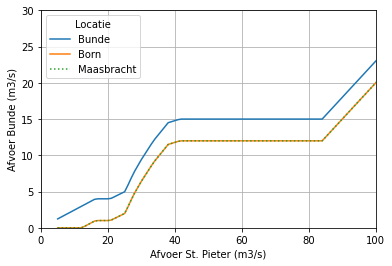

In [40]:
plt.plot(Q_SP.index, Q_JK, label='Bunde')
plt.plot(Q_SP.index, Q_Born, label='Born')
plt.plot(Q_SP.index, Q_Born, label='Maasbracht', ls=':')


plt.xlim(0, 100)
plt.ylim(0, 30)
plt.xlabel('Afvoer St. Pieter (m3/s)')
plt.ylabel('Afvoer Bunde (m3/s)')
plt.grid()
plt.legend(title='Locatie')

In [132]:
scenarios = pd.read_excel('Mockup_results.xlsx', index_col=0)

scenarios['Toename Passeertijd'] = scenarios['Passeertijd'] - scenarios.loc['Base', 'Passeertijd']

gemiddelde_kosten_per_uur = 69.4
aantal_schepen_per_week = 520
scenarios['Toename Passeerkosten'] = scenarios['Toename Passeertijd'] * aantal_schepen_per_week * gemiddelde_kosten_per_uur/60

In [133]:
scenarios['Pompkosten'] = 0

In [134]:
seconde_per_week = 7*24*60*60
pompkosten_per_seconde = 0.0048 # euro per m3

In [135]:
pompkosten = scenarios.loc['R 80 80 110', 'Debiet'] * pompkosten_per_seconde * seconde_per_week
scenarios.loc['Regimes dan pompen'] = scenarios.loc['R 80 80 110']
scenarios.loc['Regimes dan pompen', 'Debiet'] = 0
scenarios.loc['Regimes dan pompen', 'Pompkosten'] = pompkosten

In [136]:
pompkosten = scenarios.loc['Base', 'Debiet'] * pompkosten_per_seconde * seconde_per_week
scenarios.loc['Vol Pompen'] = [0, None, 0, 0, pompkosten]

In [137]:
scenarios['Totale kosten'] = (scenarios['Pompkosten'] + scenarios['Toename Passeerkosten'] ) / 7

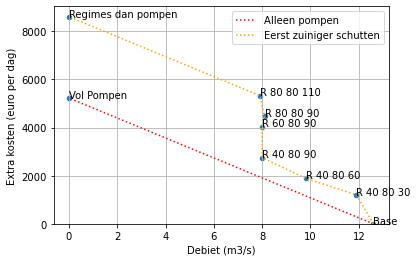

In [139]:
ax = scenarios.plot.scatter('Debiet', 'Totale kosten')
def label_point(x, y, val, ax):
    for xp, yp, valp in zip(x, y, val):
        ax.text(xp, yp, str(valp))

label_point(scenarios.Debiet, scenarios['Totale kosten'], scenarios.index, ax)


scenarios.loc[['Base', 'Vol Pompen']].plot('Debiet', 'Totale kosten', ax=ax, ls=':', c='r', label='Alleen pompen')

scenarios.iloc[:-1, :].plot('Debiet', 'Totale kosten', ax=ax, ls=':', c='orange', label='Eerst zuiniger schutten')
plt.ylim(0)
plt.ylabel('Extra kosten (euro per dag)')
plt.xlabel('Debiet (m3/s)')
plt.grid()

In [190]:
onderschrijding_Maasbracht = Q_SP * 365
onderschrijding_Maasbracht.index = Q_Maasbracht

In [191]:
onderschrijding_Maasbracht_WH2050 = Q_SP_WH2050 * 365
onderschrijding_Maasbracht_WH2050.index = Q_Maasbracht

In [162]:

def addSecond_x_axes(ax1_ticks, ax2_ticks_labels, ax2_color='#888', ax2_label=None, ax1=None, position=40):
    '''
    Add a second xlabel below the current
    
    ax1_ticks: Locations on current xaxis where markers should be placed
    ax2_ticks_labels: Labels to put at these positions
    
    ax2_color: Color of all ax2 objects
    ax2_label: xlabel
    ax1: axes to apply function on. By default uses current axes
    
    return: ax2 handle
    '''
    
    if not ax1:
        ax1=plt.gca()
        
    assert all(ax1_ticks >= ax1.get_xlim()[0]) and all(ax1_ticks <= ax1.get_xlim()[1]), 'ax1_ticks larger than xlim. Ticks: {ticks}; Limits: {limits}'.format(ticks=ax1_ticks, limits=ax1.get_xlim())
   
    ax2 = ax1.twiny()

    ax2.xaxis.tick_bottom()
    ax2.xaxis.set_label_position('bottom') 
    ax2.spines['bottom'].set_position(('outward', position))
    ax2.spines['bottom'].set_color(ax2_color)
    ax2.tick_params(axis='x', colors=ax2_color)

    ax2.set_xlim(ax1.get_xlim())

    ax2.set_xticks(ax1_ticks, )
    ax2.set_xticklabels(ax2_ticks_labels)
    ax2.set_xlabel(ax2_label, color=ax2_color)
    return ax2


In [179]:
# scenarios
s1 = scenarios.loc[['Base', 'Vol Pompen']].sort_values('Debiet')
s2 = scenarios.iloc[:-1, :].sort_values('Debiet')

s2 = s2.drop(['R 40 80 90', 'R 60 80 90']) # Make monotoom stijgend

afvoeren = onderschrijding_Maasbracht.index

s1_kosten = np.interp(afvoeren, s1['Debiet'], s1['Totale kosten'])
s2_kosten = np.interp(afvoeren, s2['Debiet'], s2['Totale kosten'])

<AxesSubplot:label='8c5813e9-dbd6-4d15-b673-747d6dd0bddb', xlabel='Kosten bij eerst zuiniger schutten (euro per dag)'>

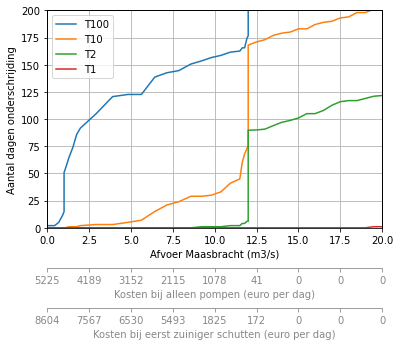

In [180]:
onderschrijding_Maasbracht.plot()
plt.legend()
plt.xlim(0, 20)
plt.ylim(0., 200)
plt.grid()
plt.ylabel('Aantal dagen onderschrijding')
plt.xlabel('Afvoer Maasbracht (m3/s)')


afvoer_xas = np.linspace(0, 20, 9)
s1_kosten_xas = np.interp(afvoer_xas, s1['Debiet'], s1['Totale kosten'])
s1_kosten_xas = [f'{s:.0f}' for s in s1_kosten_xas]
s2_kosten_xas = np.interp(afvoer_xas, s2['Debiet'], s2['Totale kosten'])
s2_kosten_xas = [f'{s:.0f}' for s in s2_kosten_xas]


addSecond_x_axes(afvoer_xas, s1_kosten_xas, ax2_label='Kosten bij alleen pompen (euro per dag)')
addSecond_x_axes(afvoer_xas, s2_kosten_xas, ax2_label='Kosten bij eerst zuiniger schutten (euro per dag)', position=80)

Text(0.5, 1.0, 'Scenario REF')

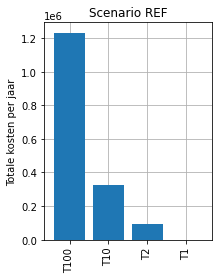

In [194]:
onderschrijding_Maasbracht.diff().multiply(s2_kosten, axis=0).sum().plot.bar(figsize=(3,4), width=0.8, zorder=3)
plt.grid()
plt.ylabel('Totale kosten per jaar')
plt.title('Scenario REF')

Text(0.5, 1.0, 'Scenario WH2050')

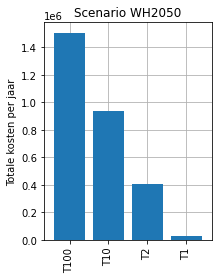

In [195]:
onderschrijding_Maasbracht_WH2050.diff().multiply(s2_kosten, axis=0).sum().plot.bar(figsize=(3,4), width=0.8, zorder=3)
plt.grid()
plt.ylabel('Totale kosten per jaar')
plt.title('Scenario WH2050')